In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('takehome_user_engagement.csv')  
df.head()
#df.shape
df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [38]:
df1 = pd.read_csv('takehome_users2.csv')
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [45]:
df.time_stamp = pd.to_datetime(df.time_stamp)
df['week'] = df['time_stamp'].dt.strftime('%U-%Y')
df_engagement = df.groupby(['user_id', 'week']).size().reset_index().rename(columns={0:'count'})
df_engagement.head()

,user_id,week,count
0,1,16-2014,1
1,2,01-2014,1
2,2,05-2014,2
3,2,06-2014,2
4,2,07-2014,1


In [59]:
df_engagement.loc[df_engagement['count'] >=3,'adopted_user'] = 1
df_engagement.loc[df_engagement['count'] <=3,'adopted_user'] = 0

counts=df_engagement['adopted_user'].value_counts()
counts

0.0    45437
1.0    24212
Name: adopted_user, dtype: int64

In [47]:
df_engagement

,user_id,week,count,adopted_user
0,1,16-2014,1,0.0
1,2,01-2014,1,0.0
2,2,05-2014,2,0.0
3,2,06-2014,2,0.0
4,2,07-2014,1,0.0
...,...,...,...,...
69644,11996,35-2013,1,0.0
69645,11997,02-2013,1,0.0
69646,11998,17-2014,1,0.0
69647,11999,22-2012,1,0.0


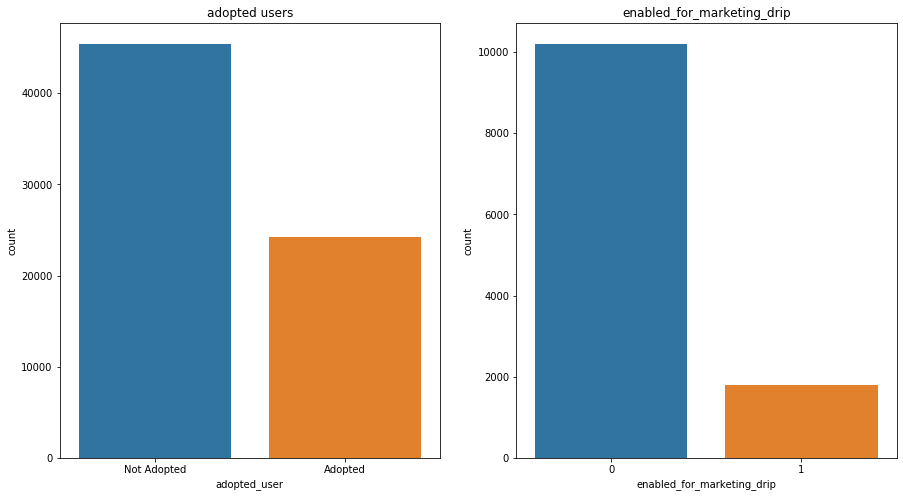

In [91]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
sns.countplot(df_engagement.adopted_user, ax=ax1)
ax1.set_xticklabels(['Not Adopted', 'Adopted'])
ax1.set_title('adopted users')


sns.countplot(df1.enabled_for_marketing_drip, ax=ax2)
ax2.set_title('enabled_for_marketing_drip')
plt.show()

In [117]:
non_adopted, adopted = df_engagement['adopted_user'].value_counts()

non_adopted_0 = df_engagement[df_engagement['adopted_user']== 0]
adopted_0 = df_engagement[df_engagement['adopted_user']==1] 

In [118]:
os = non_adopted_0.sample(adopted, replace=True)

test_over0 = pd.concat([os, non_adopted_0], axis=0)
test_over0.shape

(69649, 5)

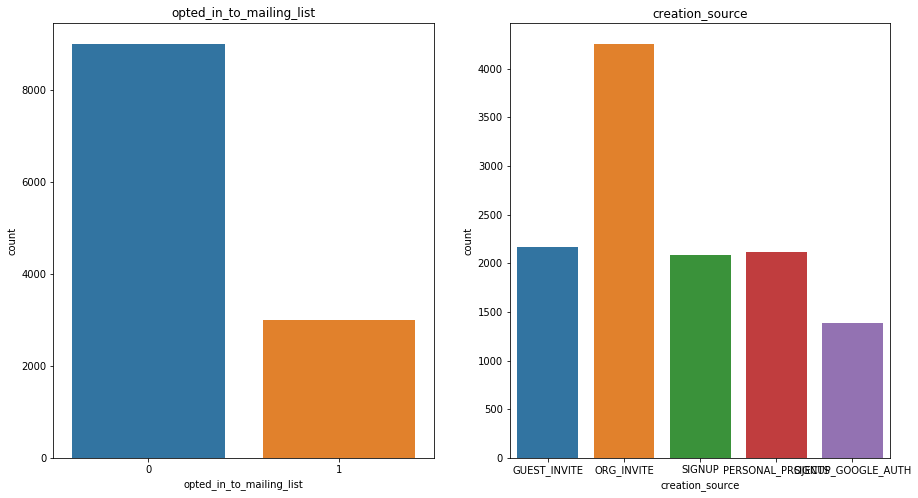

In [119]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
sns.countplot(df1.opted_in_to_mailing_list, ax=ax1)
ax1.set_title('opted_in_to_mailing_list')

sns.countplot(df1.creation_source, ax=ax2)
ax2.set_title('creation_source')
plt.show()

From the charts we see that only a few members opted for enabled marketing drip and opted_in_to_mailing_list as well as the most people that registered used the source org_invite.

In [120]:
df_users = df1.drop(['creation_time','name','email','last_session_creation_time'],1)

In [121]:
cs_onehot_features = pd.get_dummies(df_users['creation_source'])
df_users=pd.concat([df_users, cs_onehot_features], axis=1)
df_users = df_users.drop(['creation_source'],1)
df_engagement.shape

(69649, 5)

In [122]:
ad_id = df_engagement[df_engagement['count'] >=3]['user_id'].unique()
len(ad_id)

1432

In [134]:
def adopted(user_id):
    """Function to classify an user as adopted, based on the list of adoptd users provided."""
    if user_id in ad_id:
        return 1
    else:
        return 0

df_users['adopted']=df_users.object_id.apply(adopted)
df_users = df_users.fillna(0)
df_users.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,adopted
0,1,1,0,11,10803.0,1,0,0,0,0,0
1,2,0,0,1,316.0,0,1,0,0,0,0
2,3,0,0,94,1525.0,0,1,0,0,0,0
3,4,0,0,1,5151.0,1,0,0,0,0,0
4,5,0,0,193,5240.0,1,0,0,0,0,0


In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_users.drop('adopted', axis=1)
y = df_users.adopted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)

In [139]:
from sklearn.metrics import mean_squared_error as rmse, r2_score, accuracy_score, precision_score, classification_report, confusion_matrix
import random
from sklearn.model_selection import cross_val_score
random.seed(500)
model = RandomForestClassifier(n_estimators=13, random_state = 100)
model.fit(X_train, y_train);
all_accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) 
print('Accuracy = ', round(accuracy_score(y_test, y_pred),5))

[[2581   73]
 [ 332   14]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2654
           1       0.16      0.04      0.06       346

    accuracy                           0.86      3000
   macro avg       0.52      0.51      0.50      3000
weighted avg       0.80      0.86      0.83      3000

Accuracy =  0.865


In [142]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0019 ± 0.0042,opted_in_to_mailing_list
0.0007 ± 0.0046,object_id
0.0005 ± 0.0010,enabled_for_marketing_drip
-0.0001 ± 0.0024,org_id
-0.0022 ± 0.0023,PERSONAL_PROJECTS
-0.0033 ± 0.0016,SIGNUP_GOOGLE_AUTH
-0.0037 ± 0.0032,invited_by_user_id
-0.0043 ± 0.0031,ORG_INVITE
-0.0054 ± 0.0011,SIGNUP
-0.0057 ± 0.0019,GUEST_INVITE


### Final Accuarcy of 86% and Precision of 89% with a Recall of 97% 
Using random forest classifier the 3 most important features were the opted to mailing list, object id, the enable for marketing drip and the org_id.